In [1]:
from typing import Optional, Literal

import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
# from sklearn.metrics import accuracy_score, confusion_matrix

from sklearn.model_selection import RandomizedSearchCV

# Preprocessing

In [2]:
# Hossein Golmohammadi
student_id = 994023037
np.random.seed(student_id)

In [3]:
X, y = make_classification(
    n_samples=20000,
    n_features=8,
    random_state=student_id
)

In [4]:
# x_train, x_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

split_line = 0.8
q1 = int(np.ceil(X.shape[0] * split_line))
x_train, y_train = X[0:q1, :], y[0:q1]
x_test, y_test = X[q1:, :], y[q1:]

# Visualization

''

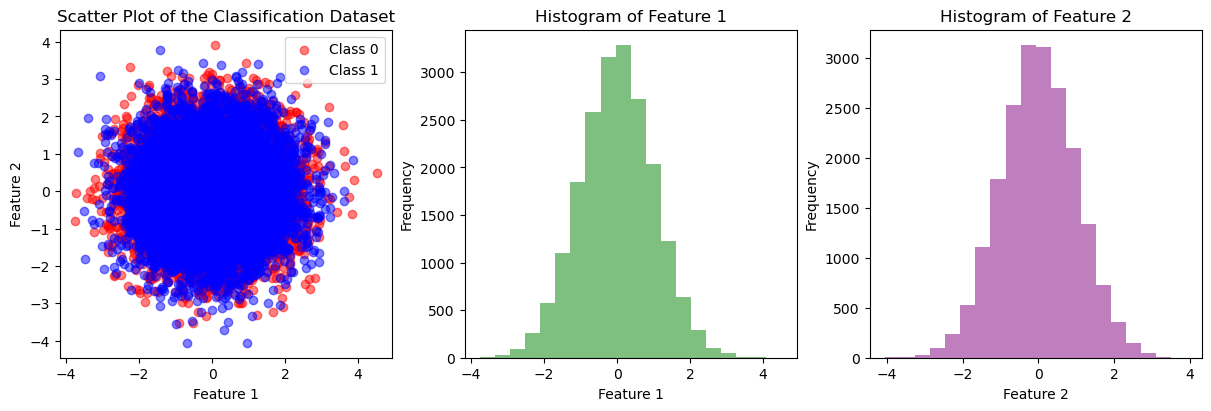

<Figure size 800x600 with 0 Axes>

In [5]:
# Scatter plot of the data
fig, ax = plt.subplots(1, 3, figsize=(12, 4), layout="constrained")

ax[0].scatter(X[y == 0, 0], X[y == 0, 1], color='red', label='Class 0', alpha=0.5)
ax[0].scatter(X[y == 1, 0], X[y == 1, 1], color='blue', label='Class 1', alpha=0.5)
ax[0].set_title('Scatter Plot of the Classification Dataset')
ax[0].set_xlabel('Feature 1')
ax[0].set_ylabel('Feature 2')
ax[0].legend()

# Histogram of the first feature
ax[1].hist(X[:, 0], bins=20, color='green', alpha=0.5)
ax[1].set_title('Histogram of Feature 1')
ax[1].set_xlabel('Feature 1')
ax[1].set_ylabel('Frequency')

# # Histogram of the second feature
plt.figure(figsize=(8, 6))
ax[2].hist(X[:, 1], bins=20, color='purple', alpha=0.5)
ax[2].set_title('Histogram of Feature 2')
ax[2].set_xlabel('Feature 2')
ax[2].set_ylabel('Frequency')

;

# Modeling

In [6]:
class KNN :
    '''
    • n_neighbors: int -> K
    • weights: {uniform, distance}
    • algorithm: brute-force search
    • metric: {Euclidean, manhattan}
    '''
    def __init__(self,
            n_neighbors,
            weights: Optional[Literal['uniform', 'distance']] = None,
            algorithm: Literal['brute-force search'] = 'brute-force search',
            metric: Optional[Literal['euclidean', 'manhattan']] = None,
            task: Literal["classification", "regression"] = "classification"
        ) :
        self.n_neighbors = n_neighbors
        self.weights = weights
        self.algorithm = algorithm
        self.metric = metric
        self.task = task
    
    def get_distance(self, x1, x2) :
        if self.metric == 'euclidean':
            distances = np.linalg.norm(x1 - x2, axis=1)
        elif self.metric == 'manhattan':
            distances = np.sum(np.abs(x1 - x2), axis=1)
        return distances
    
    @staticmethod
    def majority_vote(arr) :
        unique_values, counts = np.unique(arr, return_counts=True)
        return unique_values[np.argmax(counts)]

    
    def fit(self, X, y) :
        '''
        it is only used for receiving the X_train and y_train
        '''
        self.X_train = X
        self.y_train = y

    def predict(self, x) :
        distances = np.apply_along_axis(
            lambda row: self.get_distance(row, self.X_train),
            arr=x,
            axis=1,
        )

        top_k_indexes = np.argsort(distances, axis=1)[:, 0:self.n_neighbors]
        if self.weights == "uniform" :
            if self.task == "classification" :
                return np.apply_along_axis(
                    lambda row: np.unique(row, return_counts=True)[0][np.argmax(np.unique(row, return_counts=True)[1])],
                    arr=y_train[top_k_indexes],
                    axis=1
                )
            
        elif self.weights == "distance" :
            # ! This approach is not efficient and fast, improve it later using vectorization
            if self.task == "classification" :
                predictions = []
                # distances[np.arange(distances.shape[0])[:, None], top_k_indexes]
                weights = 1 / distances[np.arange(distances.shape[0])[:, None], top_k_indexes]
                normalized_weights = 100 * (weights / np.sum(weights, axis=0, keepdims=True))
                normalized_weights = np.ceil(normalized_weights).astype(int)
                # ! The weights may not be initialized properly, check them later

                top_k_groups = y_train[top_k_indexes]
                for row_number in range(top_k_groups.shape[0]) :
                    row = top_k_groups[row_number, :]
                    weight = normalized_weights[row_number, :]
                    try :
                        predictions.append(
                            KNN.majority_vote(np.repeat(row, weight))
                        )
                    except ValueError :
                        print(row)
                        print(weight)
                        break

                return np.array(predictions)



In [7]:
model = KNN(3, weights="uniform", metric="manhattan", task="classification")
# model = KNN(3, weights="distance", metric="manhattan", task="classification")
model.fit(x_train, y_train)

In [8]:
y_ = model.predict(x_test)

# Evaluation 

In [9]:
def accuracy_score(y_true, y_pred) :
    return (y_true == y_pred).sum() / len(y_true)

In [10]:
accuracy_score(y_train, model.predict(x_train))

0.9595

In [11]:
accuracy_score(y_test, y_)

0.93225

# Hyper parameter tuning

for hyper-parameter tuning we are going to use a method similar to `RandomizedSearchCV`.  
this method randomly chooses the parameters based on the values we define in a dictionary object (**param_grid**) and returns  
the best score and the parameters related to that.

In [12]:
def RandomSearchCV(BaseModel, param_grid, n_iter) :
    best_score = 0
    best_params = None
    for _ in range(n_iter) :
        params = {p: np.random.choice(v) for p, v in param_grid.items()}
        model = BaseModel(**params)
        model.fit(x_train, y_train)
        y_ = model.predict(x_test)
        score = accuracy_score(y_test, y_)
        if score > best_score :
            best_score = score
            best_params = params

    return best_params, best_score

In [13]:
param_grid = {
    'n_neighbors': [3, 5, 7],
    'metric': ["euclidean", "manhattan"],
    'weights': ["uniform", "distance"]
}
n_iter = 10

RandomSearchCV(KNN, param_grid, n_iter)

({'n_neighbors': 5, 'metric': 'manhattan', 'weights': 'uniform'}, 0.93425)

In [ ]:
param_grid = {
    'n_neighbors': [3, 4, 5, 7, 9],
    'metric': ["euclidean", "manhattan"],
    'weights': ["uniform"]
}
n_iter = 10

RandomSearchCV(KNN, param_grid, n_iter)